# Imports

In [1]:
# Std lib
from collections import namedtuple, Counter, defaultdict
from itertools import islice
import random
from glob import glob
from pprint import pprint as pp
from shutil import rmtree
import os

# Third party
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
from pycl.pycl import *
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from scipy import stats
from pyfaidx import Fasta
from scipy.ndimage import gaussian_filter1d
from statsmodels.stats.multitest import multipletests

# Local packages
from nanocompore.SampComp import SampComp
from nanocompore.SampComp import SampCompDB

# Matplotlib and pandas setup
%matplotlib inline
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

# Convert nanopolish model file to python dict 

In [16]:
fn = "/home/aleg/Programming/nanopolish/etc/r9-models/r9.4_70bps.u_to_t_rna.5mer.template.model"
d = {}
with open (fn) as fp:
    for line in fp:
        if not line.startswith("#") and not line.startswith("kmer"):
            ls = line.split()
            d[ls[0]] = (float(ls[1]), float(ls[2]))

fn = "/home/aleg/Programming/nanocompore/nanocompore/models.py"

with open (fn, "w") as fp:
    fp.write ("RNA_model_dict = {\n")
    for i, j in d.items():
        fp.write ("\t'{}': ({}, {}),\n".format(i,j[0], j[1]))
    fp.write ("}")

In [12]:
from nanocompore.models import RNA_model_dict

# Prepare dataset

In [9]:
ref = "./extra_data/reference/Yeast_transcriptome.fa"
dry = False

for dir in ("extra_data/basecall/", "extra_data/alignment/", "extra_data/eventalign/") :
    rmtree (dir,ignore_errors=True)
    mkdir (dir)

for lab in ("WT", "KO"):
    jprint ("Process sample", lab, bold=True, size=120)
    
    jprint ("Create directories for sample", bold=True)
    mkdir (f"extra_data/basecall/{lab}")
    mkdir (f"extra_data/alignment/{lab}") 
    mkdir (f"./extra_data/eventalign/{lab}")
    
    jprint ("Basecalling", bold=True)
    cmd = f"read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/{lab} -s extra_data/basecall/{lab}"
    bash (virtualenv="Albacore_2.3.1", cmd=cmd, print_cmd=True, dry=dry)
        
    jprint ("Aligning", bold=True)
    fastq = glob (f"./extra_data/basecall/{lab}/workspace/*.fastq")[0]
    bam = f"extra_data/alignment/{lab}/reads.bam"
    cmd = f"minimap2 -ax map-ont -L -t 4 {ref} {fastq} | samtools view -bh -F 2328 -q 30 | samtools sort -o {bam}"
    bash (virtualenv="Minimap2_2.11", cmd=cmd, live="stderr", print_cmd=True, dry=dry)
    
    jprint ("Index BAM files", bold=True)
    cmd = f"samtools index {bam}"
    bash (cmd=cmd, print_cmd=True, dry=dry)
    
    jprint ("Index fast5 files", bold=True)
    fast5_dir = f"./extra_data/raw/{lab}"
    cmd = f"nanopolish index -d {fast5_dir} {fastq}"
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr", print_cmd=True, dry=dry)
    
    jprint ("Align events", bold=True)
    bam = f"./extra_data/alignment/{lab}/reads.bam"
    ref = "./extra_data/reference/Yeast_transcriptome.fa"
    event_align_outfn = f"./extra_data/eventalign/{lab}/eventalign.tsv"
    cmd = f"nanopolish eventalign -t 4 --reads {fastq} --bam {bam} --genome {ref} --samples > {event_align_outfn}"
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr", print_cmd=True, dry=dry)
    
    jprint ("Collapse events", bold=True)
    event_align_collapsed_outfn = f"./extra_data/eventalign/{lab}/eventalign_collapsed.tsv"
    cmd = f"NanopolishComp Eventalign_collapse -t 4 -i {event_align_outfn} -o {event_align_collapsed_outfn}"
    bash (virtualenv="Nanopolish_0.10.1", cmd=cmd, live="stderr", print_cmd=True, dry=dry)

Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign


Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall/WT
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment/WT
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign/WT


read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/WT -s extra_data/basecall/WT


minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq | samtools view -bh -F 2328 -q 30 | samtools sort -o extra_data/alignment/WT/reads.bam


[M::mm_idx_gen::0.295*1.00] collected minimizers
[M::mm_idx_gen::0.377*1.59] sorted minimizers
[M::main::0.378*1.59] loaded/built the index for 6713 target sequence(s)
[M::mm_mapopt_update::0.402*1.56] mid_occ = 38
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 6713
[M::mm_idx_stat::0.419*1.53] distinct minimizers: 1527846 (95.20% are singletons); average occurrences: 1.097; average spacing: 5.416
[M::worker_pipeline::0.548*1.59] mapped 399 sequences
[M::main] Version: 2.11-r797
[M::main] CMD: minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq
[M::main] Real time: 0.557 sec; CPU: 0.878 sec


samtools index extra_data/alignment/WT/reads.bam


nanopolish index -d ./extra_data/raw/WT ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq


[readdb] indexing ./extra_data/raw/WT
[readdb] num reads: 400, num reads with path to fast5: 400


nanopolish eventalign -t 4 --reads ./extra_data/basecall/WT/workspace/fastq_runid_7bbcbb0d8612283496fbd59a410ba2e1b692d233.fastq --bam ./extra_data/alignment/WT/reads.bam --genome ./extra_data/reference/Yeast_transcriptome.fa --samples > ./extra_data/eventalign/WT/eventalign.tsv


[post-run summary] total reads: 328, unparseable: 0, qc fail: 5, could not calibrate: 0, no alignment: 0, bad fast5: 0


NanopolishComp Eventalign_collapse -t 4 -i ./extra_data/eventalign/WT/eventalign.tsv -o ./extra_data/eventalign/WT/eventalign_collapsed.tsv


[Eventalign_collapse] total reads: 323 [19.47 reads/s]


Creating /home/aleg/Programming/nanocompore/tests/extra_data/basecall/KO
Creating /home/aleg/Programming/nanocompore/tests/extra_data/alignment/KO
Creating /home/aleg/Programming/nanocompore/tests/extra_data/eventalign/KO


read_fast5_basecaller.py --disable_filtering -r -t 4 -f FLO-MIN106 -k SQK-RNA001 -o fastq -q 0 -i extra_data/raw/KO -s extra_data/basecall/KO


minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq | samtools view -bh -F 2328 -q 30 | samtools sort -o extra_data/alignment/KO/reads.bam


[M::mm_idx_gen::0.284*1.00] collected minimizers
[M::mm_idx_gen::0.364*1.57] sorted minimizers
[M::main::0.365*1.57] loaded/built the index for 6713 target sequence(s)
[M::mm_mapopt_update::0.388*1.54] mid_occ = 38
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 6713
[M::mm_idx_stat::0.405*1.51] distinct minimizers: 1527846 (95.20% are singletons); average occurrences: 1.097; average spacing: 5.416
[M::worker_pipeline::0.496*1.57] mapped 396 sequences
[M::main] Version: 2.11-r797
[M::main] CMD: minimap2 -ax map-ont -L -t 4 ./extra_data/reference/Yeast_transcriptome.fa ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq
[M::main] Real time: 0.512 sec; CPU: 0.795 sec


samtools index extra_data/alignment/KO/reads.bam


nanopolish index -d ./extra_data/raw/KO ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq


[readdb] indexing ./extra_data/raw/KO
[readdb] num reads: 400, num reads with path to fast5: 400


nanopolish eventalign -t 4 --reads ./extra_data/basecall/KO/workspace/fastq_runid_46a6d05e0ead9cb5f524f4948c32daf0aba2ab0f.fastq --bam ./extra_data/alignment/KO/reads.bam --genome ./extra_data/reference/Yeast_transcriptome.fa --samples > ./extra_data/eventalign/KO/eventalign.tsv


[post-run summary] total reads: 296, unparseable: 0, qc fail: 1, could not calibrate: 2, no alignment: 0, bad fast5: 0


NanopolishComp Eventalign_collapse -t 4 -i ./extra_data/eventalign/KO/eventalign.tsv -o ./extra_data/eventalign/KO/eventalign_collapsed.tsv


[Eventalign_collapse] total reads: 294 [20.19 reads/s]


In [2]:
head ("extra_data/eventalign/KO/eventalign_collapsed.tsv", ignore_comment_line=True)

ref_pos ref_kmer n_events NNNNN_events mismatching_events mean       median  n_signals 
144     AGAGG    1        0            0                  124.20087  124.223 43        
145     GAGGT    2        0            0                  104.763405 104.707 36        
146     AGGTG    1        0            0                  114.68939  113.547 10        
147     GGTGC    2        0            0                  109.89428  109.195 28        
148     GTGCA    2        0            0                  88.36677   87.0261 56        
149     TGCAG    1        0            0                  107.35894  107.495 11        
150     GCAGC    2        0            0                  94.35902   93.6223 48        
151     CAGCT    2        0            0                  107.90285  110.351 15        
152     AGCTG    7        0            0                  117.151    117.287 135       



# Dev whitelist function

In [12]:
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx")
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv")

ref_id  ref_start ref_end read_id                              kmers NNNNN_kmers mismatching_kmers missing_kmers byte_offset byte_len 
YHR055C 0         171     6f885af6-5844-476e-9e51-133dc5617dfd 169   3           0                 2             0           8279     
YHR055C 1         182     2b01d98a-336e-40d9-b7c4-07895b9b10a2 175   6           0                 6             8280        8584     
YHR055C 0         155     4259fc88-b781-482a-bfa9-985dc424c733 154   5           0                 1             16865       7234     
YHR055C 0         170     d3bcaffe-3020-4a0b-a913-254a96e92efd 167   2           0                 3             24100       8211     
YHR055C 0         182     d978ef9e-b4b0-4998-ab41-6d9da2c50743 171   6           0                 11            32312       8386     
YHR055C 0         182     5baf52a9-27be-411b-9023-3d7681e60e90 177   5           0                 5             40699       8704     
YHR055C 1         172     0fd6188c-af31-43c0-bc69-3ced8

In [66]:
def whitelist (
    s1_fn,
    s2_fn,
    fasta_index_fn = None,
    min_cov = 10,
    max_NNNNN_kmers_freq = 0.2,
    max_mismatching_kmers_freq = 0.2,
    max_missing_kmers_freq = 0.2,
    verbose=True):

    # Read fasta index
    if verbose: print ("Read fasta index")
    ref_len_dict = _read_fasta_index (fn=fasta_index_fn)
    if verbose: print (f"\tTotal references: {len(ref_len_dict)}")

    # Create reference index for both files
    if verbose: print ("Read eventalign index files")
    ref_reads = _read_eventalign_index (s1_fn, s2_fn, max_NNNNN_kmers_freq, max_mismatching_kmers_freq, max_missing_kmers_freq)
    if verbose: print (f"\tTotal references found {len(ref_reads)}")
    
    # Intersect both samples
    if verbose: print ("Filter out references with low coverage")
    ref_reads = _select_ref (ref_reads=ref_reads, min_cov=min_cov)
    if verbose: print (f"\tTranscripts remaining after reference coverage filtering: {len(ref_reads)}")
    
    if verbose: print ("Compute coverage per reference and select intervals with high enough coverage")
    ref_interval_reads = OrderedDict ()
    for ref_id, sample_reads in ref_reads.items ():
        # Compute reference coverage
        cov_array = _compute_ref_cov (sample_reads=sample_reads, ref_len=ref_len_dict[ref_id])
        # Get coordinates of intervals with minimum coverage
        valid_interval_list = _get_valid_intervals (cov_array, min_cov)
        # Intesect reads with valid coverage for both samples
        ref_interval_reads [ref_id] = _intersect_reads_interval (valid_interval_list, sample_reads)
    
    return ref_interval_reads
        
def _read_fasta_index (fn):
    ref_len = OrderedDict ()
    with open (fn) as fp:
        for line in fp:
            ls = line.rstrip().split()
            ref_len[ls[0]] = int(ls[1])
    return ref_len

def _read_eventalign_index (s1_fn, s2_fn, max_NNNNN_kmers_freq, max_mismatching_kmers_freq, max_missing_kmers_freq):
    ref_reads = OrderedDict ()
    
    for lab, fn in ("S1", s1_fn), ("S2", s2_fn):
        with open (fn) as fp:
            # get field names from header
            header = fp.readline().rstrip().split()
            line_tuple = namedtuple("line_tuple", header)
            c = Counter ()
            for line in fp:
                ls = line.rstrip().split()
                lt = line_tuple (ls[0], int(ls[1]), int(ls[2]), ls[3], int(ls[4]), int(ls[5]) , int(ls[6]) , int(ls[7]) , int(ls[8]))
                # filter out reads with high number of problematic kmers
                if max_NNNNN_kmers_freq and lt.NNNNN_kmers/lt.kmers > max_NNNNN_kmers_freq:
                    c ["high NNNNN_kmers reads"] += 1
                elif max_mismatching_kmers_freq and lt.mismatching_kmers/lt.kmers > max_mismatching_kmers_freq:
                    c ["high mismatching_kmers reads"] += 1
                elif max_missing_kmers_freq and lt.missing_kmers/lt.kmers > max_missing_kmers_freq:
                    c ["high missing_kmers reads"] += 1
                # Save valid reads
                else:
                    if not lt.ref_id in ref_reads:
                        ref_reads[lt.ref_id] = OrderedDict ()
                    if not lab in ref_reads [lt.ref_id]:
                        ref_reads[lt.ref_id][lab] = []
                    ref_reads[lt.ref_id][lab].append (lt)
                    c ["valid reads"] += 1
        print (c)
    return ref_reads

def _select_ref (ref_reads, min_cov):
    invalid_ref = []
    for ref_id, sample_reads in ref_reads.items ():
        if len(sample_reads) < 2 or len (sample_reads["S1"]) < min_cov or len (sample_reads["S2"]) < min_cov:
            invalid_ref.append (ref_id)
    for ref_id in invalid_ref:
        del ref_reads [ref_id]
    return ref_reads

def _compute_ref_cov (sample_reads, ref_len):
    cov_array = np.zeros ((2, ref_len))
    for read in sample_reads["S1"]:
        cov_array [0][np.arange(read.ref_start, read.ref_end)] += 1
    for read in sample_reads["S2"]:
        cov_array [1][np.arange(read.ref_start, read.ref_end)] += 1
    return cov_array
        
def _get_valid_intervals (cov_array, min_cov):
    valid_cov = False
    valid_interval_list = []
    for pos, (cov1, cov2) in enumerate (cov_array.T):
        # If coverage insuficient
        if cov1 < min_cov or cov2 < min_cov:
            if valid_cov:
                valid_interval_list.append ((ref_start, ref_end))
            valid_cov = False
        # If the coverage is high enough for both samples
        else:
            if valid_cov:
                ref_end = pos
            else:
                ref_start = ref_end = pos
                valid_cov = True
    # Last valid interval exception
    if valid_cov:
        valid_interval_list.append ((ref_start, ref_end))
    
    return valid_interval_list

def _intersect_reads_interval (valid_interval_list, sample_reads):
    
    ref_interval_reads = OrderedDict ()
    for interval_start, interval_end in valid_interval_list:
        ref_interval_reads [(interval_start, interval_end)] = {"S1":[], "S2":[]}
    
    for sample_id, read_list in sample_reads.items():
        for read in read_list:
            for interval_start, interval_end in valid_interval_list: 
                if read.ref_end >= interval_start and read.ref_start <= interval_end:
                    ref_interval_reads[(interval_start, interval_end)][sample_id].append (read)
    return ref_interval_reads

In [75]:
sample1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
sample2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/Nanopore_yeast/references/SC_R64-1-1_transcripts.fa.fai"
w  = whitelist (sample1_fn, sample2_fn, fasta_index_fn, min_cov=5, max_NNNNN_kmers_freq=0.1, max_mismatching_kmers_freq=0.1, max_missing_kmers_freq=0.1)

Read fasta index
	Total references: 6713
Read eventalign index files
Counter({'valid reads': 11073, 'high missing_kmers reads': 927, 'high mismatching_kmers reads': 344, 'high NNNNN_kmers reads': 84})
Counter({'valid reads': 10802, 'high missing_kmers reads': 702, 'high mismatching_kmers reads': 384, 'high NNNNN_kmers reads': 84})
	Total references found 2126
Filter out references with low coverage
	Transcripts remaining after reference coverage filtering: 172
Compute coverage per reference and select intervals with high enough coverage


# Test whitelist from package

In [7]:
from nanocompore.Whitelist import Whitelist

In [8]:
sample1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
sample2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa"
w  = Whitelist (sample1_fn, sample2_fn, fasta_index_fn, min_coverage=10, max_NNNNN_freq=0.1, max_mismatching_freq=0.1, max_missing_freq=0.1, logLevel="debug")

Initialise Whitelist and checks options
Index Fasta file
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 69,855	S1_reads: 8,272	S2_reads: 6,584	ref_id: 77
	References remaining after reference coverage filtering: 77
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 77/77 [00:00<00:00, 274.32 References/s]
	positions: 28,967	S1_reads: 8,204	S2_reads: 6,528	intervals: 76	ref_id: 74
	References remaining after position coverage filtering: 74


In [9]:
for ref_id, ref_dict in islice(w.ref_interval_reads.items(), 10000):
    if len(ref_dict["interval_list"]) >=2: 
        jprint (ref_id, bold=True, size=150)
        pp (ref_dict["interval_list"])
        with pd.option_context("display.max_rows", 4):
            display (pd.DataFrame(ref_dict["S1"]))
            display (pd.DataFrame(ref_dict["S2"]))

[(270, 439), (461, 1372)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,byte_offset,byte_len
0,YPR080W,1,1373,b8f4cdcc-1bb8-4aaa-bf73-b8e66d59835c,1321,34,0,51,216943049,64682
1,YPR080W,1,1373,058d4ad2-98c8-44c8-80ec-ee8e7aac6871,1326,39,0,46,217007732,65084
...,...,...,...,...,...,...,...,...,...,...
77,YPR080W,1190,1352,819abeb7-87d7-4834-9ab2-9dbc92176812,155,6,0,7,218937078,7856
78,YPR080W,1271,1373,416f3e0c-035e-4b4f-bd3e-d727344d0888,93,4,0,9,218952302,4800


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,byte_offset,byte_len
0,YPR080W,1,1371,3aac5b9e-17d3-4dd9-98a5-76db265d13f8,1301,52,0,69,137547875,63731
1,YPR080W,0,1373,de291062-8ed6-412f-b353-06267a562ea5,1333,35,0,40,137611607,65514
...,...,...,...,...,...,...,...,...,...,...
166,YPR080W,1174,1370,4a7d7b77-805c-4393-a78b-282105cc8c2c,183,4,0,13,145203941,9298
167,YPR080W,1149,1373,a91851ff-1f31-43c7-997b-da20b1f59d77,219,3,0,5,145213240,11072


[(270, 439), (461, 1372)]


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,byte_offset,byte_len
0,YBR118W,1,1373,058d4ad2-98c8-44c8-80ec-ee8e7aac6871,1326,39,0,46,230337370,65084
1,YBR118W,1,1373,b8f4cdcc-1bb8-4aaa-bf73-b8e66d59835c,1321,34,0,51,230402455,64676
...,...,...,...,...,...,...,...,...,...,...
77,YBR118W,1190,1352,819abeb7-87d7-4834-9ab2-9dbc92176812,155,6,0,7,232394789,7856
78,YBR118W,1271,1373,416f3e0c-035e-4b4f-bd3e-d727344d0888,93,4,0,9,232402646,4800


,ref_id,ref_start,ref_end,read_id,kmers,NNNNN_kmers,mismatching_kmers,missing_kmers,byte_offset,byte_len
0,YBR118W,1,1370,a020fbca-7ad7-4678-90a2-741ca8ca57c7,1306,45,0,63,184342060,64035
1,YBR118W,0,1373,de291062-8ed6-412f-b353-06267a562ea5,1333,35,0,40,184406096,65515
...,...,...,...,...,...,...,...,...,...,...
166,YBR118W,1173,1370,75fa4f1b-7a5e-4c45-b86b-8064e93b0d42,188,7,0,9,192000935,9500
167,YBR118W,1174,1370,4a7d7b77-805c-4393-a78b-282105cc8c2c,183,4,0,13,192010436,9298


In [11]:
s1_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv.idx"
s2_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv.idx"
fasta_index_fn = "/home/aleg/Analyses/Nanopore_yeast/references/SC_R64-1-1_transcripts.fa.fai"

w  = Whitelist (s1_index_fn, s2_index_fn, fasta_index_fn, min_coverage=15, max_NNNNN_kmers_freq=0.1, max_mismatching_kmers_freq=0.1, max_missing_kmers_freq=0.1, logLevel="debug")

Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 39,312	S1_reads: 7,959	S2_reads: 5,934	ref_id: 50
	References remaining after reference coverage filtering: 50
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 50/50 [00:00<00:00, 299.82 References/s]
	positions: 15,054	S1_reads: 7,841	S2_reads: 5,659	intervals: 47	ref_id: 45
	References remaining after position coverage filtering: 45


In [10]:
w.ref_id_list[:10]

['YKL096W-A',
 'YLR029C',
 'YLR249W',
 'YKR059W',
 'YOR369C',
 'YJR145C',
 'YKL006W',
 'YOL120C',
 'YNL069C',
 'YGR282C']

In [11]:
w.to_bed ("/home/aleg/Analyses/RNA_Yeast_TRM5/test/whitelist.bed")
head ("/home/aleg/Analyses/RNA_Yeast_TRM5/test/whitelist.bed")

YKL096W-A 0    274  
YLR029C   174  607  
YLR249W   2928 3110 
YKR059W   751  1182 
YOR369C   1    427  
YJR145C   392  781  
YKL006W   104  412  
YOL120C   4    554  
YNL069C   167  580  
YGR282C   524  930  



# nanopolish eventalign parser

In [15]:
from nanocompore.helper_lib import mytqdm
from nanocompore.Whitelist import Whitelist

class SampComp (object):
    def __init__ (self, s1_fn, s2_fn, whitelist):
        self.__whitelist = whitelist
        self.__s1_fn = s1_fn
        self.__s2_fn = s2_fn
        self.__logLevel = "info"

    def read_eventalign (self):
        
          with open (self.__s1_fn) as s1_fp, open (self.__s2_fn) as s2_fp: # Open only once
                pbar = mytqdm (total = len(self.__whitelist), unit=" References", disable=self.__logLevel == "warning")
                for ref_id, ref_dict in self.__whitelist:
                    pbar.update ()
                    
                    # Init empty dict for all positions in valid intervals
                    position_dict = OrderedDict ()
                    for interval_start, interval_end in ref_dict["interval_list"]:
                        for i in range (interval_start, interval_end+1):
                            position_dict[i] = {"S1_mean":[], "S1_dwell":[], "S2_mean":[], "S2_dwell":[]}

                    # Parse S1 and S2 reads data and add to mean and dwell time per position
                    for lab, fp in (("S1", s1_fp), ("S2", s2_fp)):
                        for read in ref_dict[lab]:

                            # Move to read save read data chunk and reset file pointer 
                            fp.seek (read.byte_offset)
                            read_lines = fp.read (read.byte_len)
                            fp.seek (0)
                    
                            # Check if positions are in the ones found in the whitelist intervals 
                            for line in read_lines.split("\n")[2:]:
                                ls = line.split("\t")
                                ref_pos = int(ls[0])
                                
                                # Append mean value and dwell time
                                if ref_pos in position_dict:
                                    position_dict[ref_pos][lab+"_mean"].append(float(ls[8]))
                                    position_dict[ref_pos][lab+"_dwell"].append(int(ls[9]))
                    
                    yield ((ref_id, position_dict))


# Test SampComp

In [25]:
# -*- coding: utf-8 -*-

#~~~~~~~~~~~~~~IMPORTS~~~~~~~~~~~~~~#
# Std lib
import logging
from collections import defaultdict, OrderedDict, namedtuple, Counter
import os
import shelve
import multiprocessing as mp

# Third party
import numpy as np

# Local package
#from nanocompore.txCompare import txCompare
from nanocompore.helper_lib import mkdir, access_file, mytqdm
from nanocompore.Whitelist import Whitelist
from nanocompore.NanocomporeError import NanocomporeError

# Logger setup
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)
logLevel_dict = {"debug":logging.DEBUG, "info":logging.INFO, "warning":logging.WARNING}

#~~~~~~~~~~~~~~MAIN FUNCTION~~~~~~~~~~~~~~#
class SampComp (object):
    """ Produce useful results. => Thanks Tommaso ! That's a very *useful* comment :P """

    def __init__(self,
        s1_fn,
        s2_fn,
        whitelist,
        output_db_fn,
        padj_threshold = 0.1,
        comparison_method = "kmean",
        nthreads = 4,
        logLevel = "info",):

        """
        Main routine that starts readers and consumers
            s1_fn: path to a nanopolish eventalign collapsed file corresponding to sample 1
            s2_fn: path to a nanopolish eventalign collapsed file corresponding to sample 2
            outfolder: path to folder where to save output
            nthreads: number of consumer threads
            whitelist_dict: Dictionnary generated by nanocopore whitelist function
        """
        # Set logging level
        logger.setLevel (logLevel_dict.get (logLevel, logging.WARNING))
        logger.info ("Initialise and checks options")
        
        # Check args
        if not isinstance (whitelist, Whitelist):
            raise NanocomporeError("Whitelist is not valid")
        for fn in (s1_fn, s2_fn):
            access_file (fn)
        if nthreads < 3:
            raise NanocomporeError("Number of threads not valid")
        #mkdir (outfolder)    
        
        # Save private args
        self.__logLevel = logLevel
        self.__padj_threshold = padj_threshold
        self.__whitelist = whitelist
        self.__s1_fn = s1_fn
        self.__s2_fn = s2_fn
        self.__output_db_fn = output_db_fn
        self.__nthreads = nthreads-2
        
        logger.info ("Start data processing")
        
        # Init Multiprocessing variables
        in_q = mp.Queue (maxsize = 1000)
        out_q = mp.Queue (maxsize = 1000)

        # Define processes
        ps_list = []
        ps_list.append (mp.Process (target=self._read_eventalign_files, args=(in_q,)))
        for i in range (self.__nthreads):
            ps_list.append (mp.Process (target=self._process_references, args=(in_q, out_q)))
        ps_list.append (mp.Process (target=self._write_output, args=(out_q,)))

        # Start processes and block until done
        try:
            for ps in ps_list:
                ps.start ()
            for ps in ps_list:
                ps.join ()

        # Kill processes if early stop
        except (BrokenPipeError, KeyboardInterrupt) as E:
            if self.verbose: stderr_print ("Early stop. Kill processes\n")
            for ps in ps_list:
                ps.terminate ()
    
    def _read_eventalign_files (self, in_q):      
        # Add refid to inqueue to dispatch the data among the workers
        with open (self.__s1_fn) as s1_fp, open (self.__s2_fn) as s2_fp:                
            for ref_id, ref_dict in self.__whitelist:

                # Init empty dict for all positions in valid intervals
                position_dict = OrderedDict ()
                for interval_start, interval_end in ref_dict["interval_list"]:
                    for i in range (interval_start, interval_end+1):
                        position_dict[i] = {"S1_mean":[], "S1_dwell":[], "S2_mean":[], "S2_dwell":[]}

                # Parse S1 and S2 reads data and add to mean and dwell time per position
                for lab, fp in (("S1", s1_fp), ("S2", s2_fp)):
                    for read in ref_dict[lab]:

                        # Move to read save read data chunk and reset file pointer 
                        fp.seek (read.byte_offset)
                        read_lines = fp.read (read.byte_len)
                        fp.seek (0)

                        # Check if positions are in the ones found in the whitelist intervals 
                        for line in read_lines.split("\n")[2:]:
                            ls = line.split("\t")
                            ref_pos = int(ls[0])

                            # Append mean value and dwell time
                            if ref_pos in position_dict:
                                position_dict[ref_pos][lab+"_mean"].append(float(ls[8]))
                                position_dict[ref_pos][lab+"_dwell"].append(int(ls[9]))
                    
                in_q.put ((ref_id, position_dict))
                    
        # Add 1 poison pill for each worker thread
        for i in range (self.__nthreads):
            in_q.put (None)
    
    def _process_references (self, in_q, out_q): 
        # Consumme ref_id until a poison pill is found
        for ref_id, position_dict in iter (in_q.get, None):
            # Do stats with position_dict
            ####### position_dict = tx_compare (padj_threshold, comparison_method) ## Add p-value per position to the position_dict. #######
            # Add the current read details to queue
            out_q.put ((ref_id, position_dict))
        
        # Add poison pill in queues
        out_q.put (None)
    
    def _write_output (self, out_q):
        
        with shelve.open (self.__output_db_fn) as db:
            # Iterate over the counter queue and process items until all poison pills are found
            pbar = tqdm (total = len(self.__whitelist), unit=" Processed References", disable=self.__logLevel=="warning")
            for _ in range (self.__nthreads):
                for ref_id, stat_dict in iter (out_q.get, None):
                    # Write results in a shelve db to get around multithreaded isolation
                    db [ref_id] = stat_dict 
                    pbar.update ()
            pbar.close()
                    

# Dev TxComp module

In [13]:
from nanocompore.SampComp import SampComp

s = SampComp (
    max_NNNNN_freq=0.1,
    max_mismatching_freq=0.1,
    max_missing_freq=0.1,
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_index_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa.fai",
    nthreads=8,
    min_coverage=25,
    logLevel = "debug")

Initialise and checks options
Initialise and checks options
Read fasta index files
	Total references: 6713
Read eventalign index files
	Sample S1 	valid reads: 11,073	high missing_kmers reads: 927	high mismatching_kmers reads: 344	high NNNNN_kmers reads: 84
	Sample S2 	valid reads: 10,802	high missing_kmers reads: 702	high mismatching_kmers reads: 384	high NNNNN_kmers reads: 84
	References found in index: 2126
Filter out references with low coverage
	positions: 13,023	S1_reads: 7,301	S2_reads: 4,337	ref_id: 13
	References remaining after reference coverage filtering: 13
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 13/13 [00:00<00:00, 61.76 References/s]
	S1_reads: 7,267	positions: 6,012	S2_reads: 4,332	intervals: 13	ref_id: 13
	References remaining after position coverage filtering: 13
Start data processing
100%|██████████| 13/13 [00:35<00:00,  9.61s/ Processed References]


In [17]:
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind, combine_pvalues
import random

def paired_test (ref_pos_dict, method="mann_whitney", sequence_context=0, min_coverage=20):

    # Predefine stat test
    if method in ["mann_whitney", "MW"]:
        stat_test = mannwhitneyu
    elif method in ["kolmogorov_smirnov", "KS"]:
        stat_test = ks_2samp
    elif method in ["t_test", "TT"]:
        stat_test = ttest_ind
    else:
        raise NanocomporeError ("Invalid statistical method name (MW, KS, ttest)")
    
    # Perform pair comparison position per position if coverage is sufficient    
    res_dict = OrderedDict ()
    
    for pos, pos_dict in tqdm (ref_pos_dict.items()):
        if pos_dict["S1_count"] >= min_coverage and pos_dict["S2_count"] >= min_coverage:
            res_dict[pos] = OrderedDict ()
            
            # Number of batch tests dependent on coverage
            n_batch = (max((pos_dict["S1_count"], pos_dict["S2_count"]))*2)//min_coverage
            
            # Compute 
            for var in ("median", "dwell"):
                s1_data = pos_dict["S1_"+var]
                s2_data = pos_dict["S2_"+var]
                pval_array = np.empty (shape=n_batch, dtype=np.float64)
                for i in range (n_batch):
                    pval_array[i] = stat_test (np.random.choice (s1_data, min_coverage), np.random.choice (s2_data, min_coverage))[1]
                res_dict[pos][var] = np.mean (pval_array)

    if not sequence_context:
        return res_dict
    
    # If a sequence context is required combine adjacent pvalues with fishers method when possible
    else:
        res_dict_combined = OrderedDict()

        for mid_pos in res_dict.keys():
            pval_median_list = []
            pval_dwell_list = []

            try:
                for pos in range (mid_pos-sequence_context, mid_pos+sequence_context+1):
                    pval_median_list.append (res_dict [pos]["median"])
                    pval_dwell_list.append (res_dict [pos]["dwell"])

                res_dict_combined [mid_pos] = OrderedDict()
                res_dict_combined [mid_pos]["median"] = stats.combine_pvalues (pval_median_list, method='fisher') [1]
                res_dict_combined [mid_pos]["dwell"] = stats.combine_pvalues (pval_dwell_list, method='fisher') [1]
            
            # In case at least one of the adjacent position is missing
            except KeyError:
                pass

        return res_dict_combined

mann_whitney

100%|██████████| 412/412 [00:00<00:00, 586.11it/s] 


kolmogorov_smirnov

100%|██████████| 412/412 [00:00<00:00, 985.72it/s] 


t_test

100%|██████████| 412/412 [00:00<00:00, 483.15it/s] 


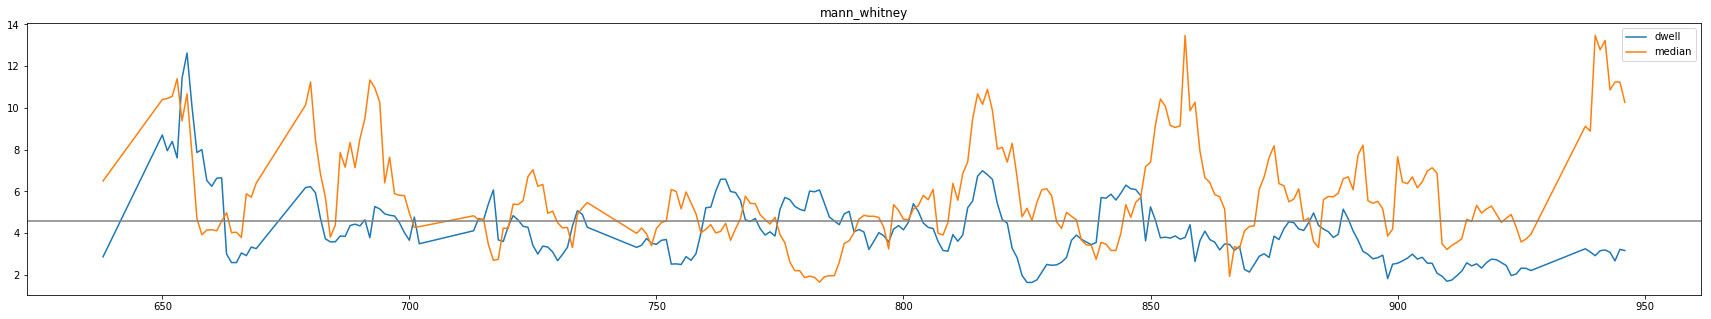

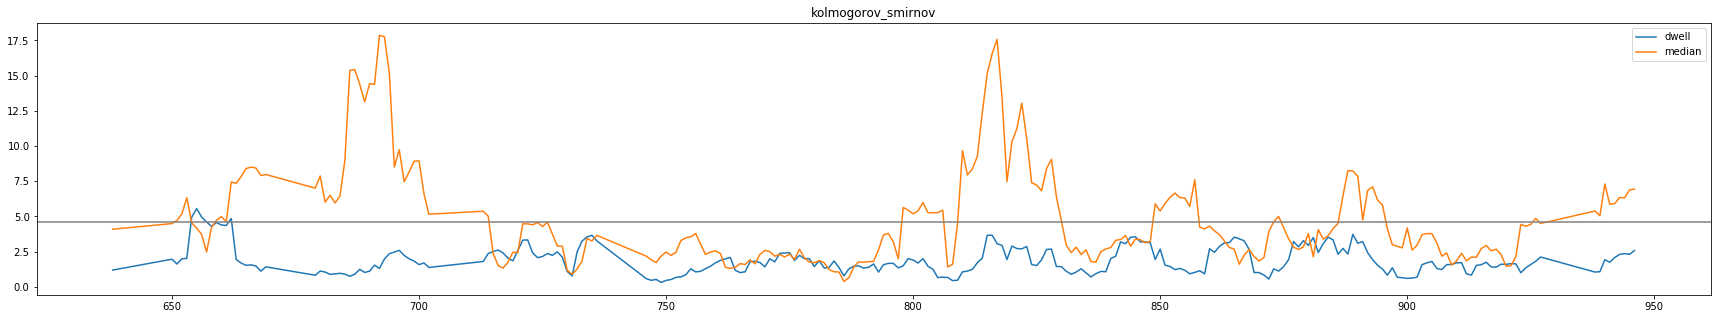

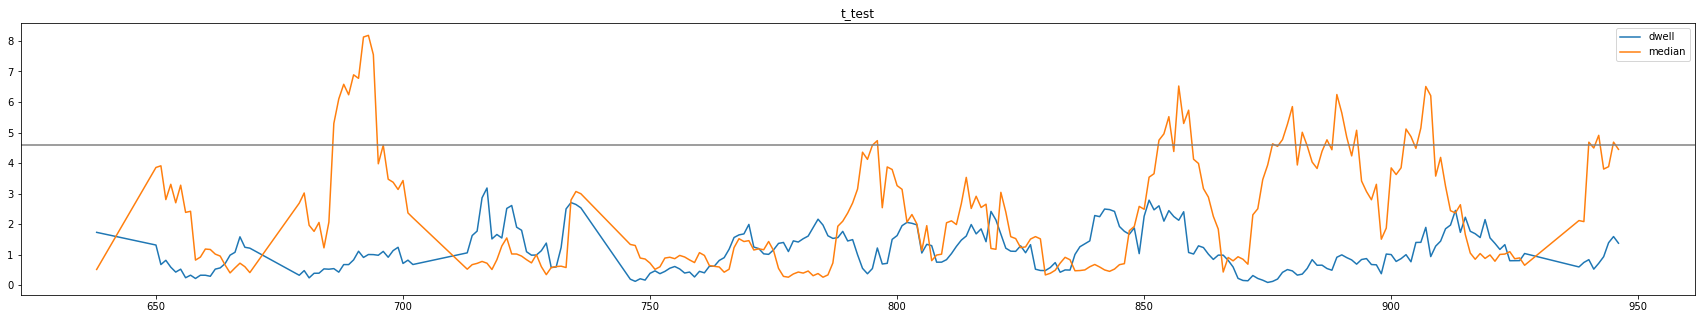

In [19]:
ref_dict = s["YMR116C"]
sig_lim = -np.log (0.01)

for method in ("mann_whitney", "kolmogorov_smirnov", "t_test"):
    stdout_print (method)
    res_dict = paired_test (ref_dict, method=method, sequence_context=4, min_coverage=30)
    fig, ax = pl.subplots (figsize=(30,5))
    df = -np.log (pd.DataFrame (res_dict)).transpose()
    _ = df.plot(ax=ax)
    _ = ax.axhline (sig_lim, c="gray")
    _ = ax.set_title (method)

YMR116C

100%|██████████| 412/412 [00:02<00:00, 137.67it/s]


YBR118W

100%|██████████| 556/556 [00:12<00:00, 45.43it/s]


YPR080W

100%|██████████| 556/556 [00:14<00:00, 38.43it/s]


YLR110C

100%|██████████| 397/397 [00:11<00:00, 35.46it/s]


YGL135W

100%|██████████| 38/38 [00:00<00:00, 170.05it/s]


YLR044C

100%|██████████| 240/240 [00:04<00:00, 58.50it/s]


YJR009C

100%|██████████| 400/400 [00:09<00:00, 43.37it/s]


YGR254W

100%|██████████| 939/939 [00:39<00:00, 23.79it/s]


YGR192C

100%|██████████| 513/513 [00:35<00:00, 14.48it/s]


YKL060C

100%|██████████| 433/433 [00:05<00:00, 79.69it/s]


YPL220W

100%|██████████| 38/38 [00:00<00:00, 167.61it/s]

YDR524C-B


100%|██████████| 193/193 [00:01<00:00, 112.24it/s]


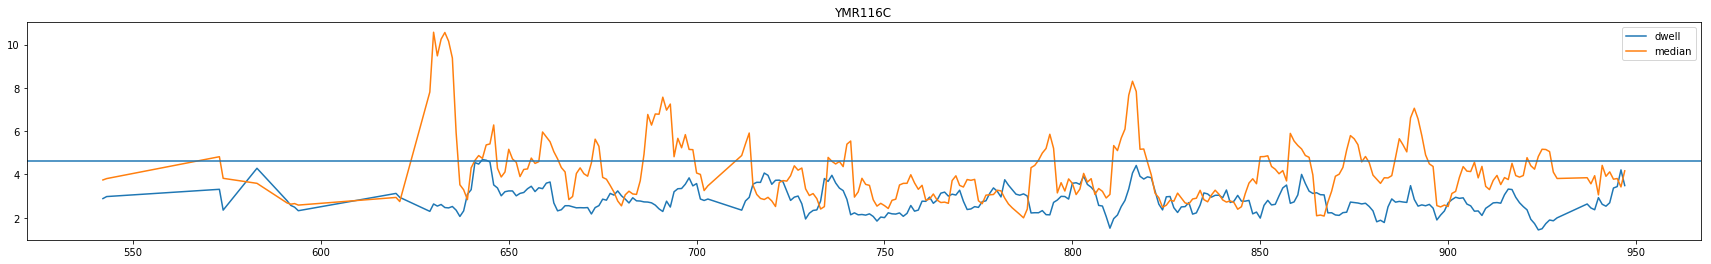

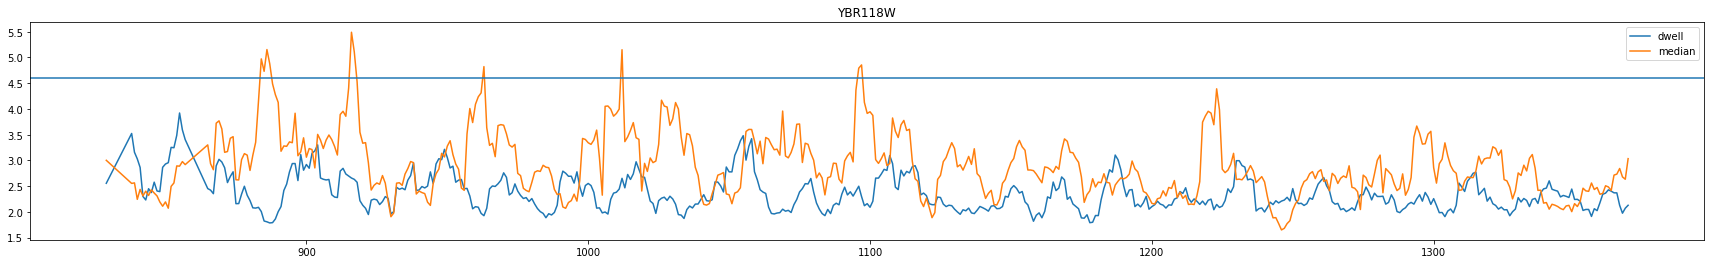

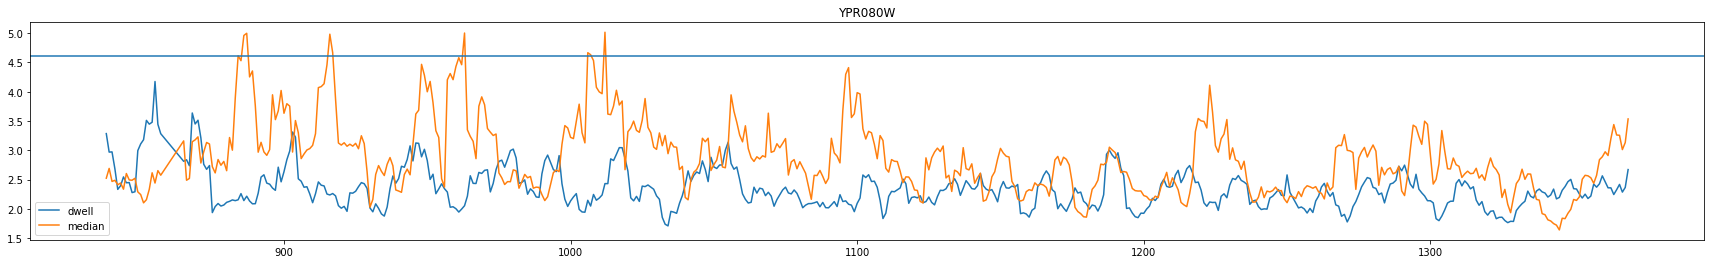

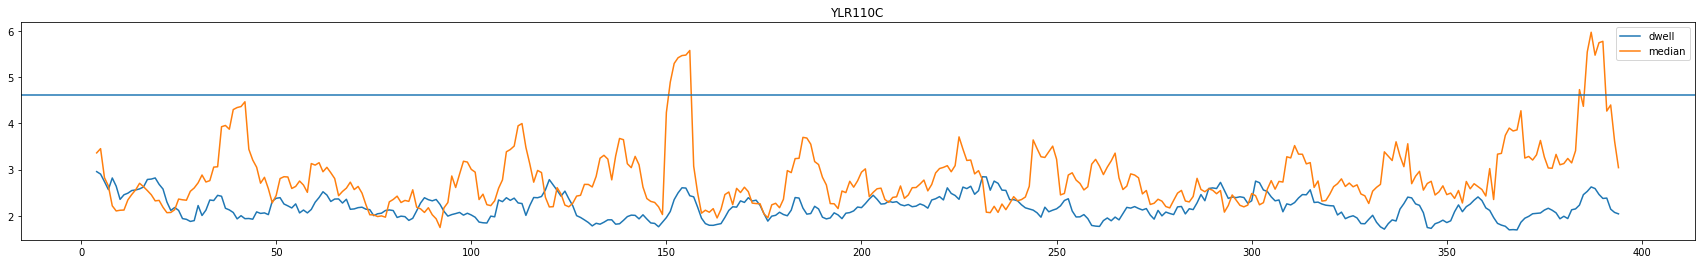

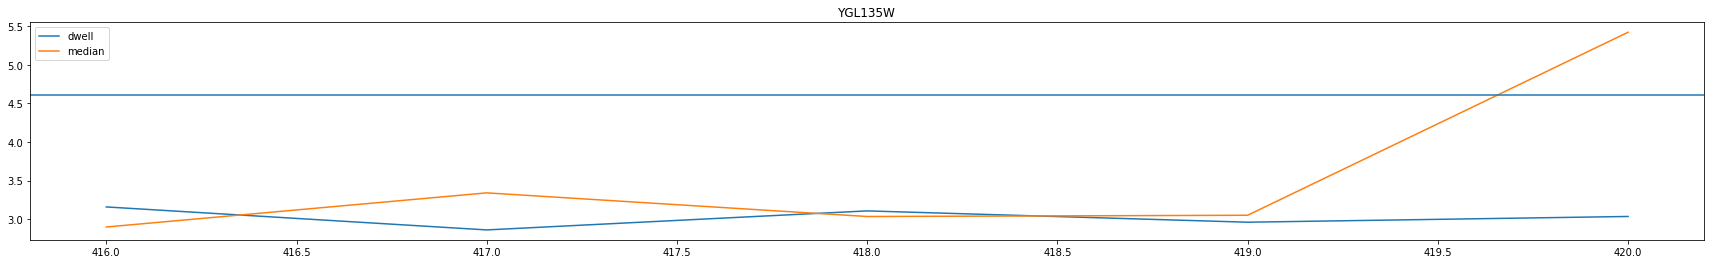

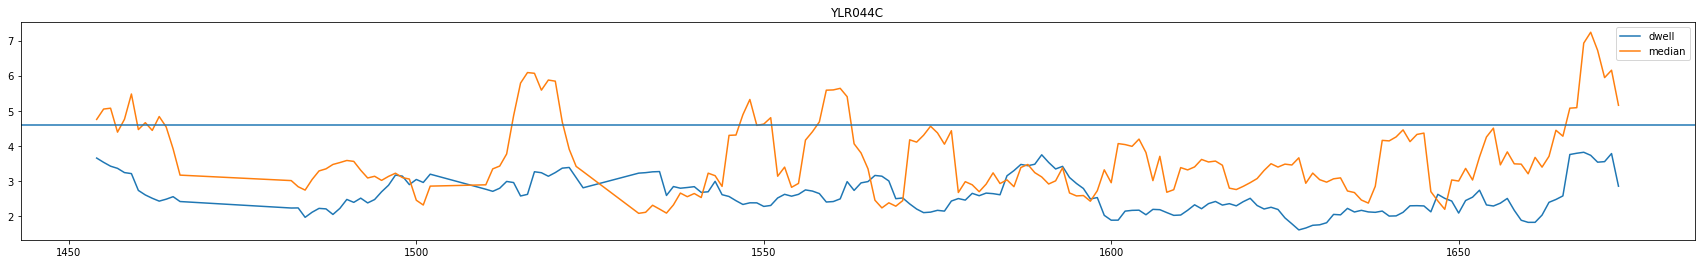

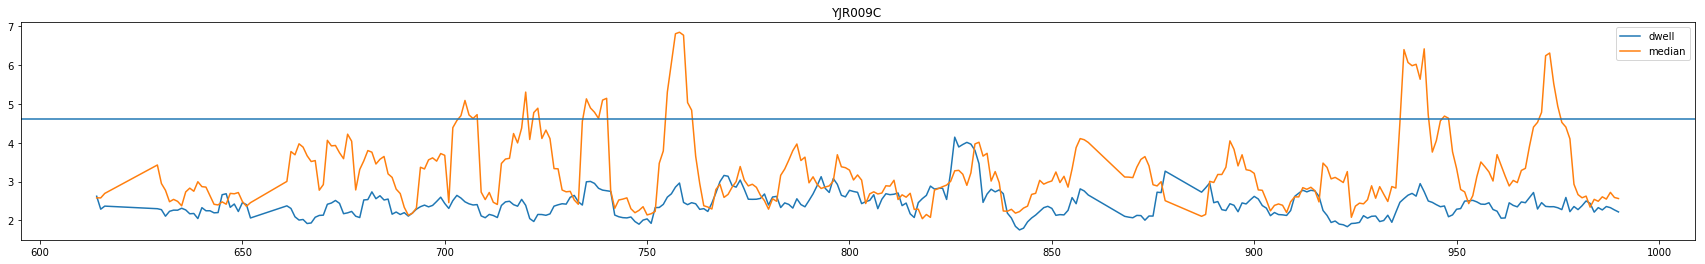

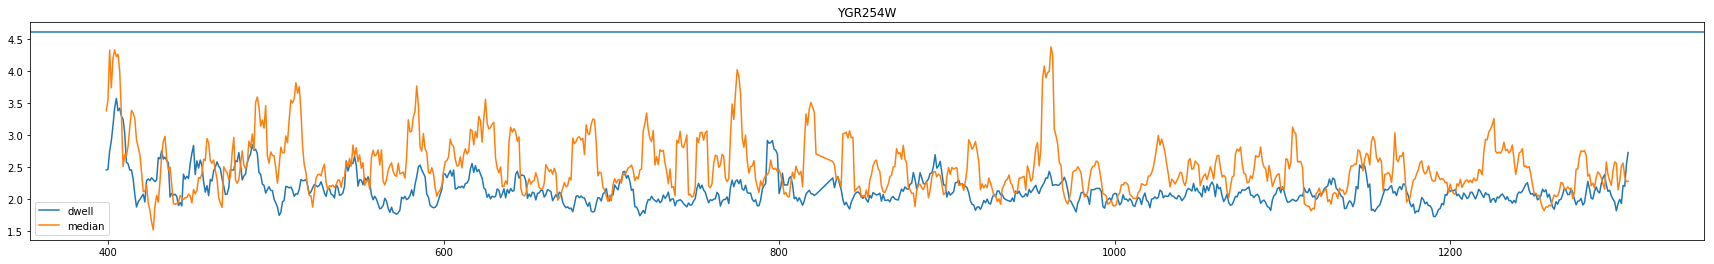

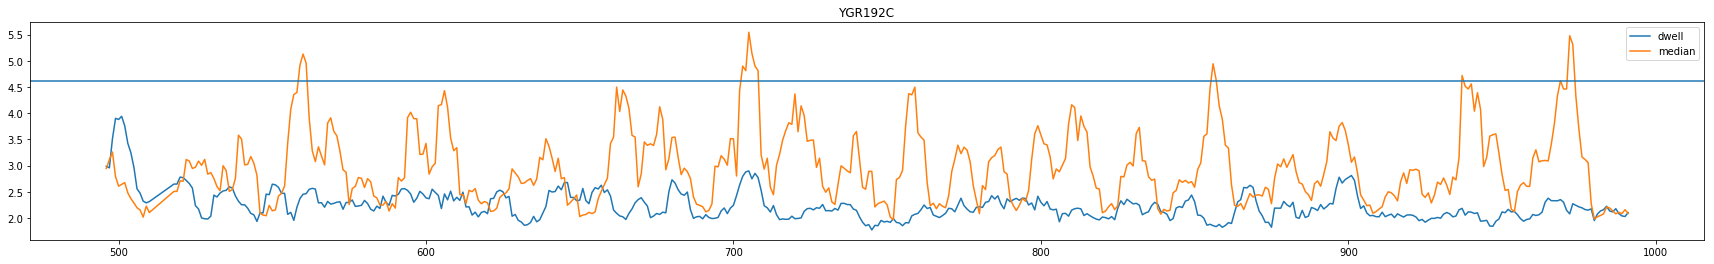

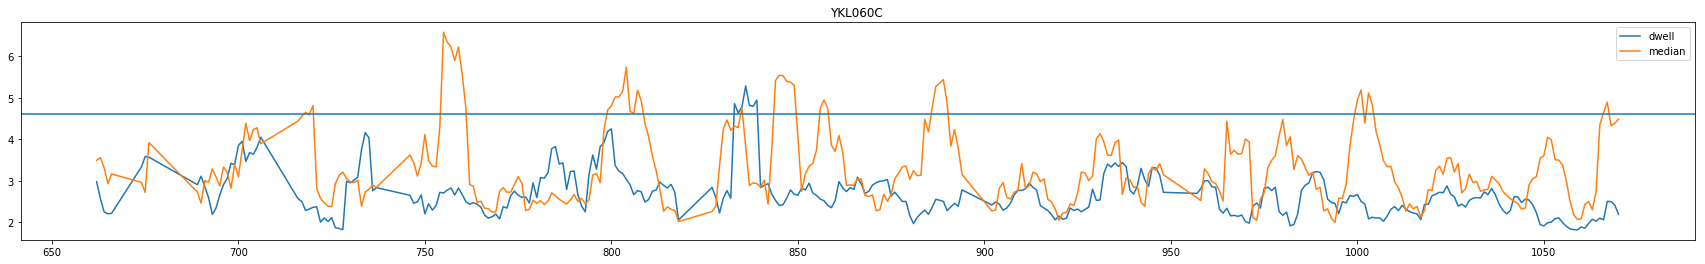

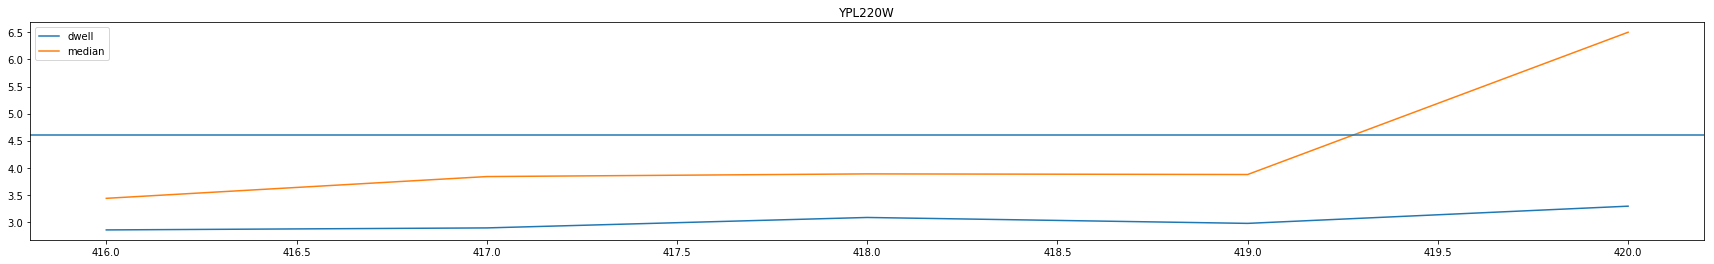

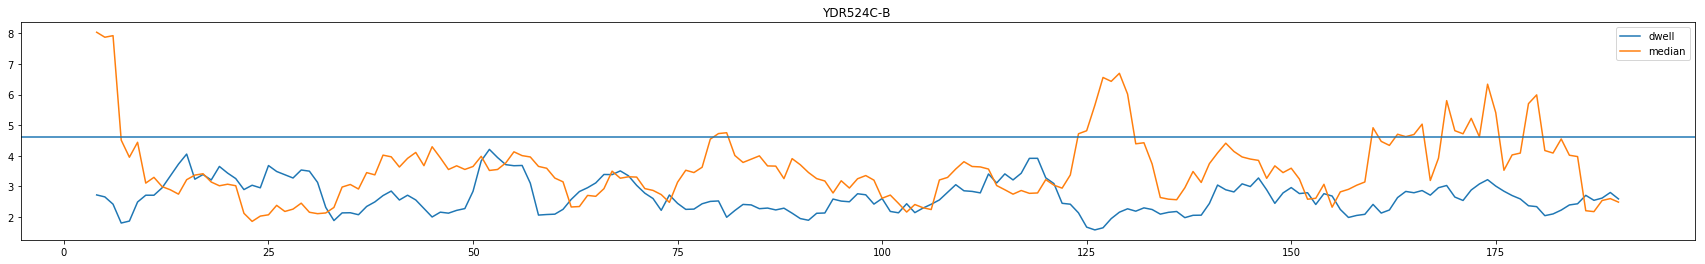

In [16]:
lim = -np.log(0.01)

for ref_id, ref_dict in s:
    if ref_id == "YHR174W":
        continue
    stdout_print (ref_id)
    res_dict = paired_test (ref_dict, method="mann_whitney", sequence_context=3, min_coverage=25)
    
    if res_dict:
        fig, ax = pl.subplots (figsize=(30,4))
        df = -np.log (pd.DataFrame(res_dict)).transpose()
        _ = df.plot (ax=ax)
        _ = ax.axhline (lim)
        _ = ax.set_title (ref_id)

# Test Mixture model

In [3]:
s = SampComp ( 
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa",
    nthreads=8,
    min_coverage=20,
    comparison_method = ["kmean"],
    sequence_context = 2,
    downsample_high_coverage = 500,
    logLevel = "info")

db = s()
print (db)

Initialise SampComp and checks options
Initialise Whitelist and checks options
Index Fasta file
Read eventalign index files
	References found in index: 2208
Filter out references with low coverage
	References remaining after reference coverage filtering: 27
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 27/27 [00:00<00:00, 184.41 References/s]
	References remaining after position coverage filtering: 23
Start data processing
100%|██████████| 23/23 [01:26<00:00,  5.41s/ Processed References]


[SampCompDB] Number of references: 22



In [73]:
db = SampCompDB (db_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db", fasta_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa")
db.ref_id_list

['YOL120C',
 'YMR116C',
 'YOR369C',
 'YCR031C',
 'YLR167W',
 'YBR118W',
 'YDR382W',
 'YDR012W',
 'YAL038W',
 'YNL162W',
 'YHR141C',
 'YPR080W',
 'YLR110C',
 'YGL135W',
 'YCR012W',
 'YLR044C',
 'YJR009C',
 'YGR254W',
 'YGR192C',
 'YHR174W',
 'YKL060C',
 'YPL220W',
 'YDR524C-B']

In [5]:
db.calculate_results()

IndexError: index 41 is out of bounds for axis 0 with size 41

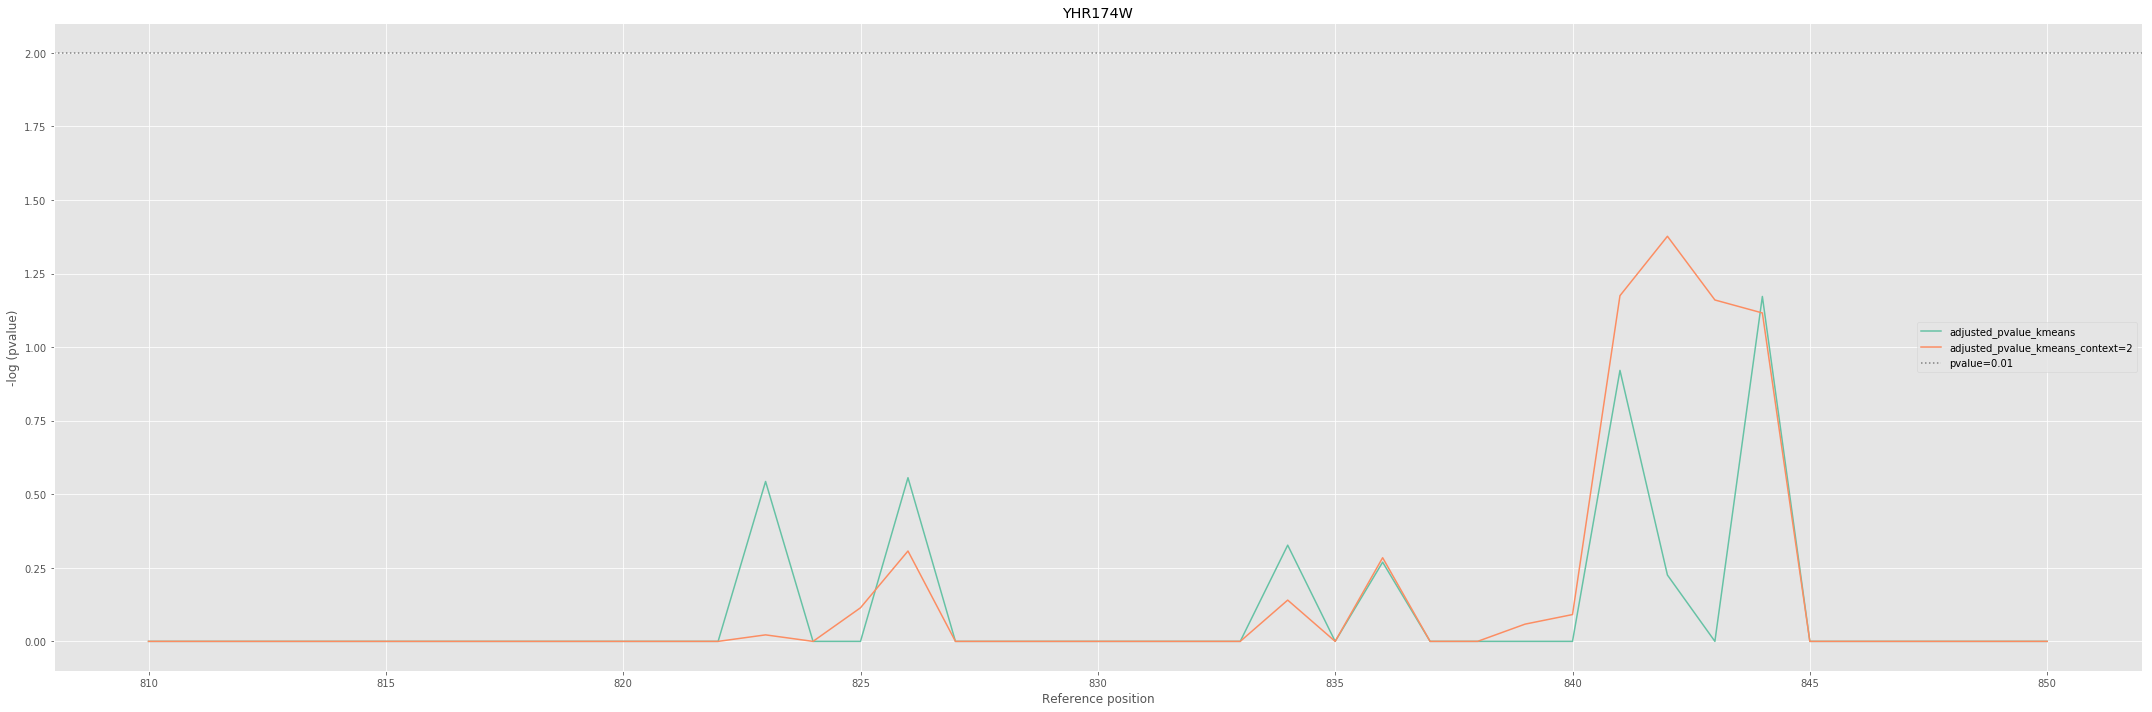

In [6]:
ref = 'YHR174W'
start = 810
end = 850

fig, ax = db.plot_pvalue (ref, start, end)
fig, ax = db.plot_coverage (ref, start, end)

In [23]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [24]:
gmm = GaussianMixture (n_components=2, covariance_type="full")
gmm.

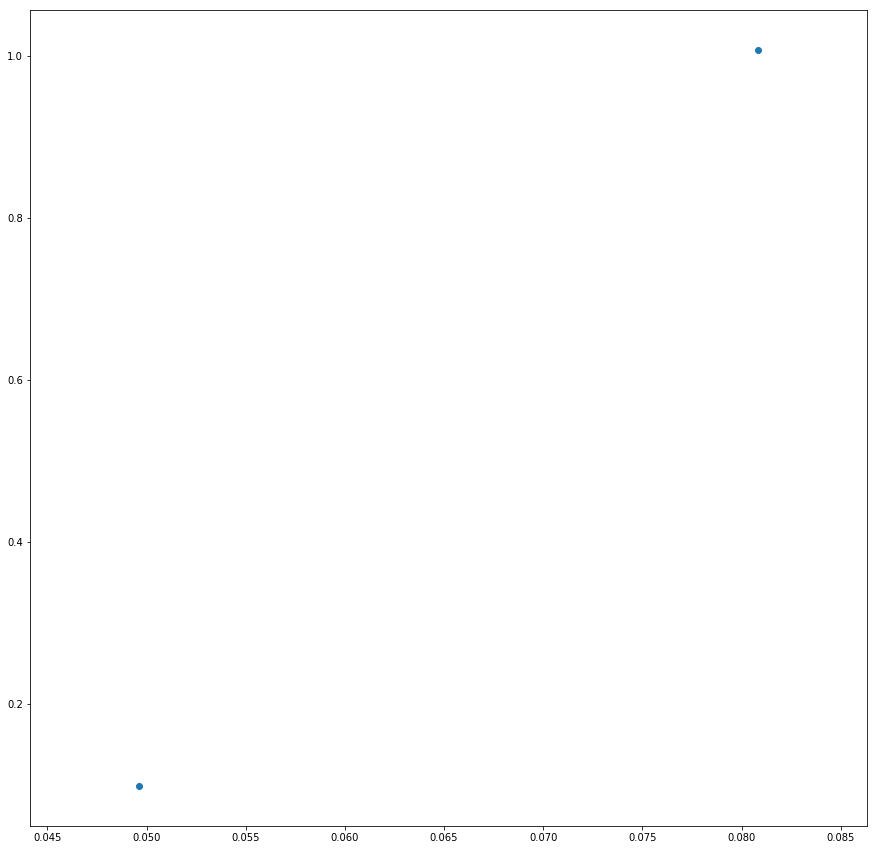

In [17]:
n_samples=100


fig, ax = pl.subplots (figsize=(15,15))
ax.scatter(X[0], X[1])

# Test Package

In [5]:
s = SampComp (
    max_NNNNN_freq=0.1,
    max_mismatching_freq=0.1,
    max_missing_freq=0.1,
    s1_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/KO/eventalign_collapsed.tsv",
    s2_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/eventalign/WT/eventalign_collapsed.tsv",
    output_db_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db",
    fasta_fn = "/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa",
    nthreads=8,
    min_coverage=20,
    comparison_method = ["kmean", "KS", "MW"],
    sequence_context = 2,
    downsample_high_coverage = 200,
    logLevel = "info")

db = s()
print (db)

Initialise SampComp and checks options
Initialise Whitelist and checks options
Index Fasta file
Read eventalign index files
	References found in index: 2126
Filter out references with low coverage
	References remaining after reference coverage filtering: 19
Compute coverage per reference and select intervals with high enough coverage
100%|██████████| 19/19 [00:00<00:00, 139.05 References/s]
	References remaining after position coverage filtering: 14
Start data processing
100%|██████████| 14/14 [01:00<00:00,  3.86s/ Processed References]


[SampCompDB] Number of references: 13



### plot_pvalues

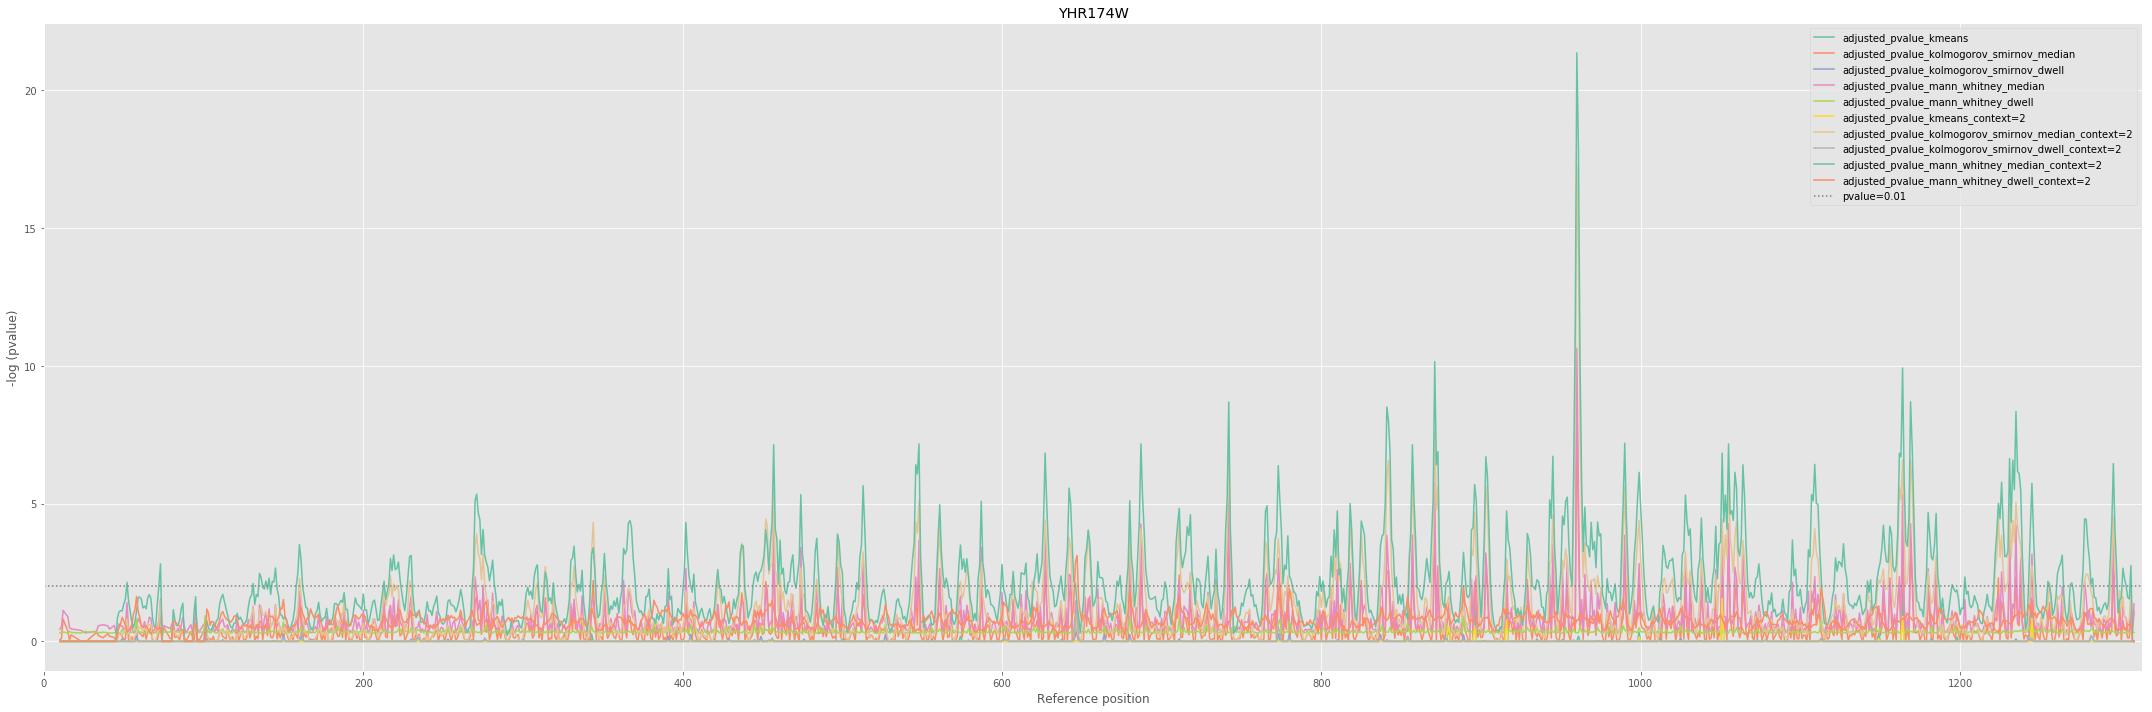

In [2]:
db = SampCompDB (db_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db", fasta_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa")
db.calculate_results()
fig, ax = db.plot_pvalue ("YHR174W", palette="Set2", adjusted_pvalues=True)

In [ ]:
for ref in db.ref_id_list:
    fig, ax = db.plot_pvalue (ref, palette="Set2", adjusted_pvalues=True)

### Plot Coverage

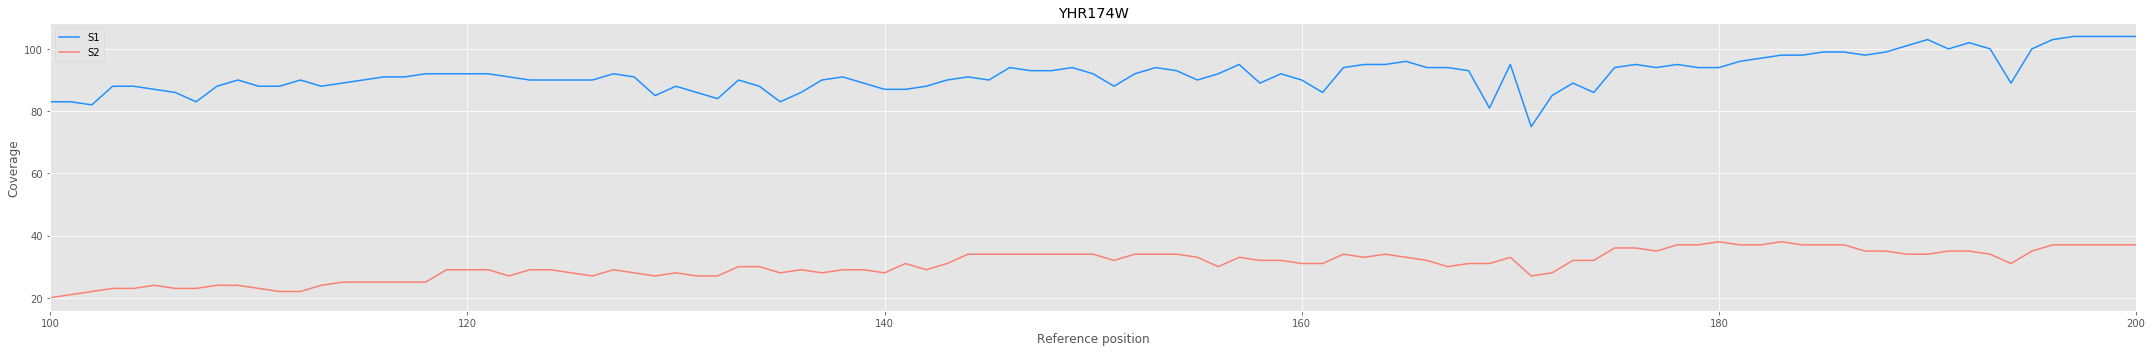

In [5]:
db = SampCompDB (db_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db", fasta_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa")
fig, ax = db.plot_coverage("YHR174W", start=100, end=200)

### Plot signal

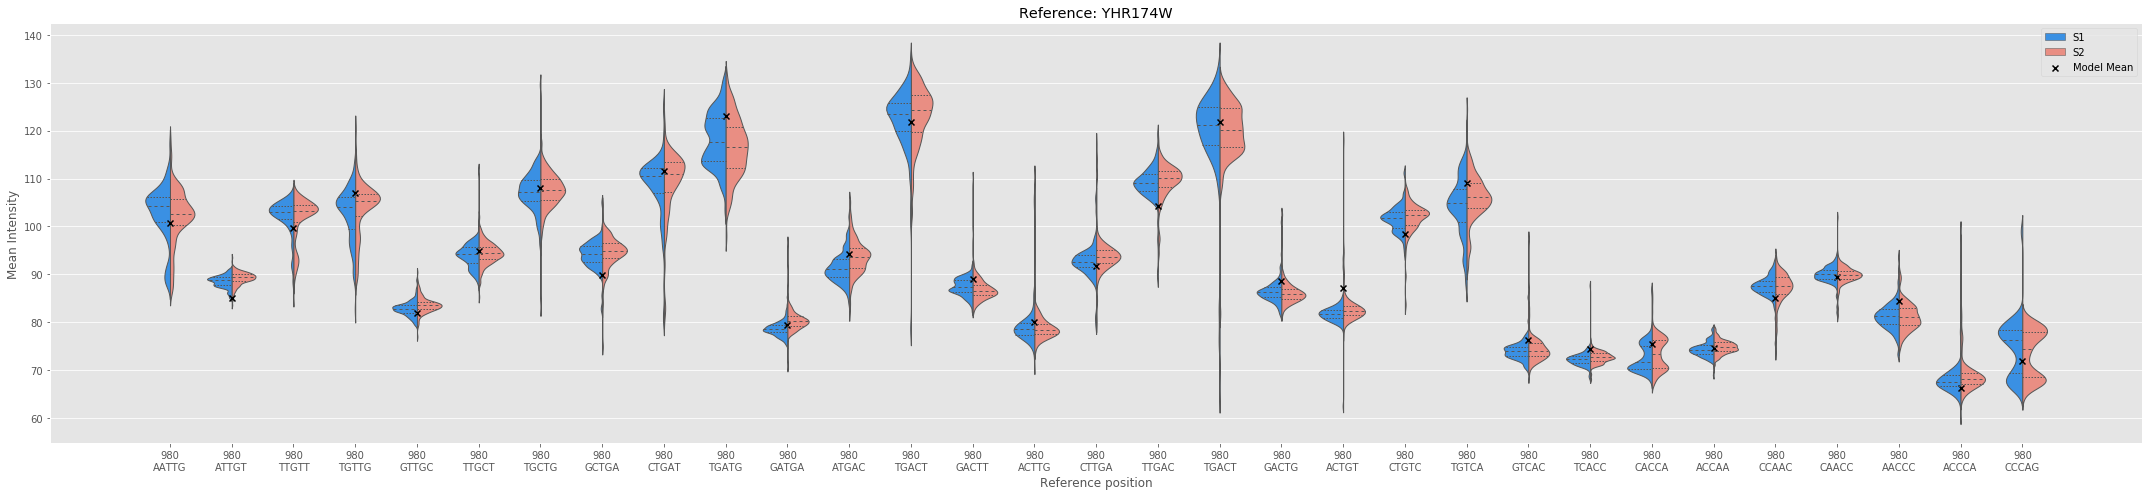

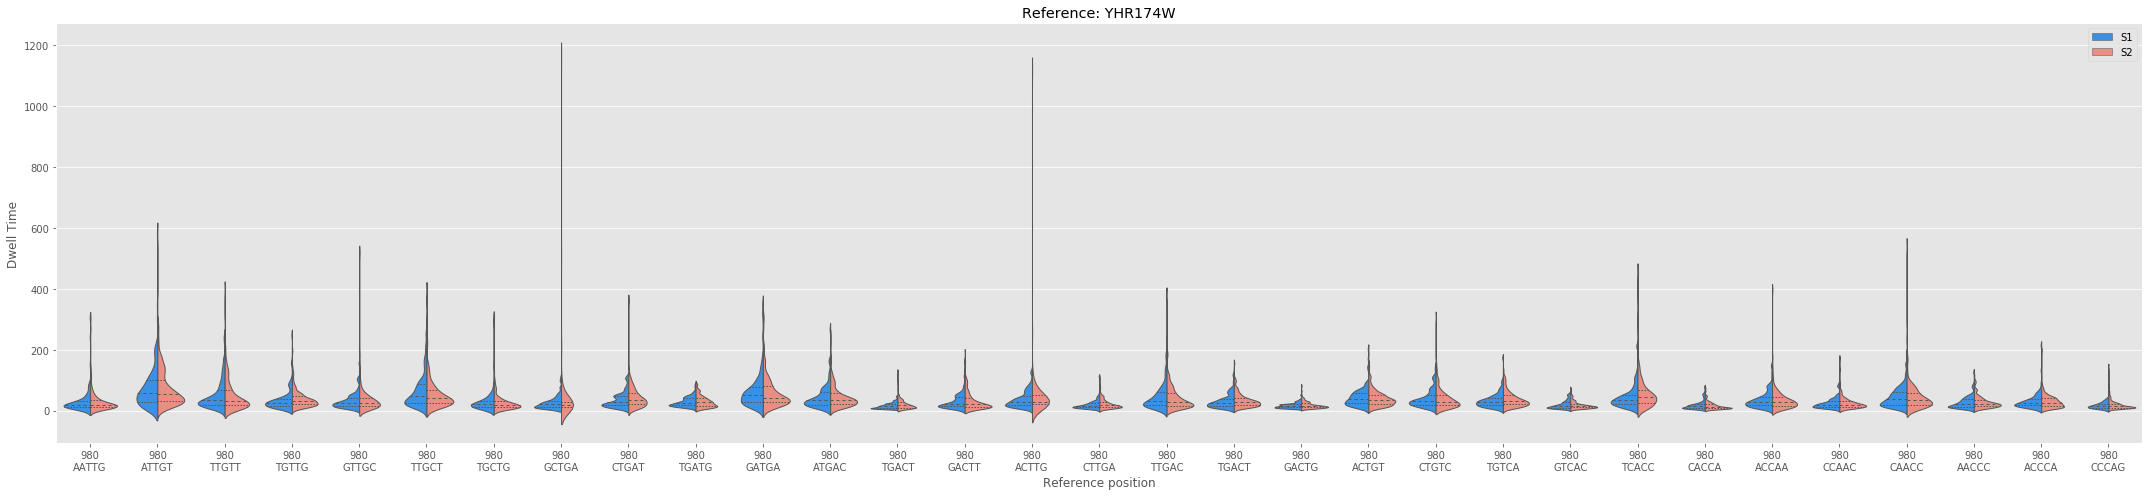

In [2]:
db = SampCompDB (db_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db", fasta_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa")
fig, ax = db.plot_signal ("YHR174W", start=950, end=980, feature="mean_intensity")
fig, ax = db.plot_signal ("YHR174W", start=950, end=980, feature="dwell_time")

### plot all

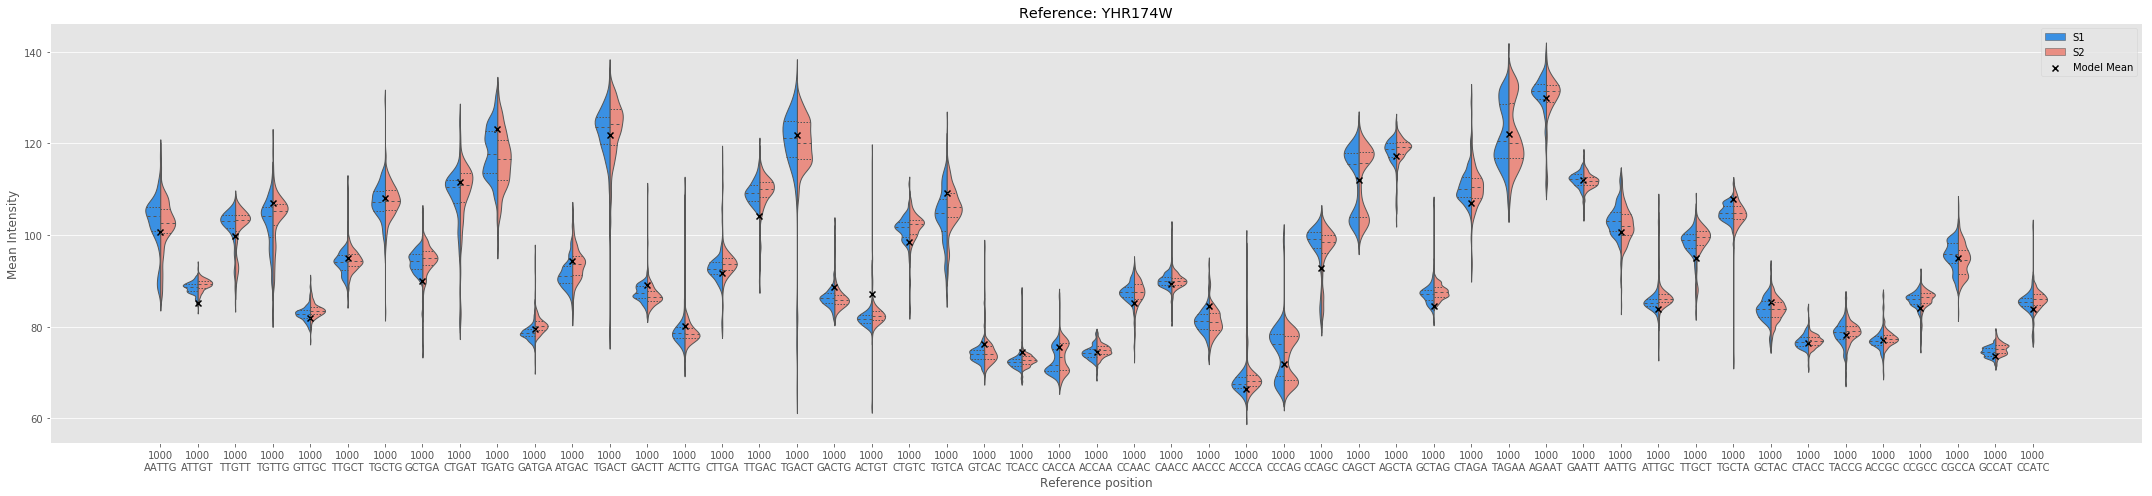

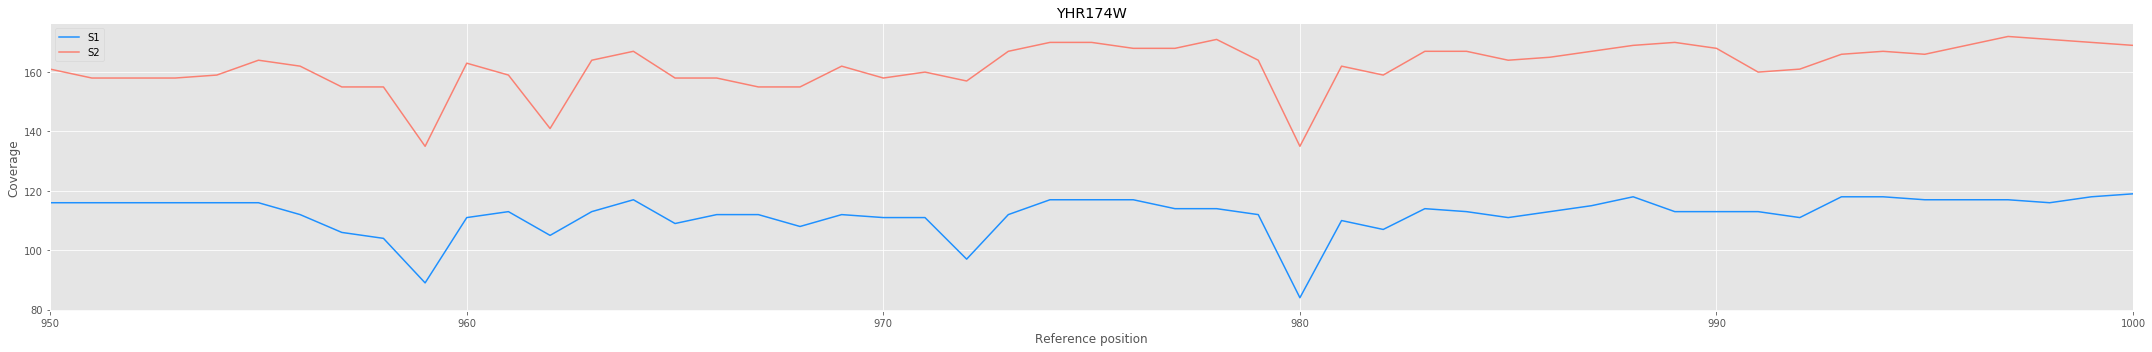

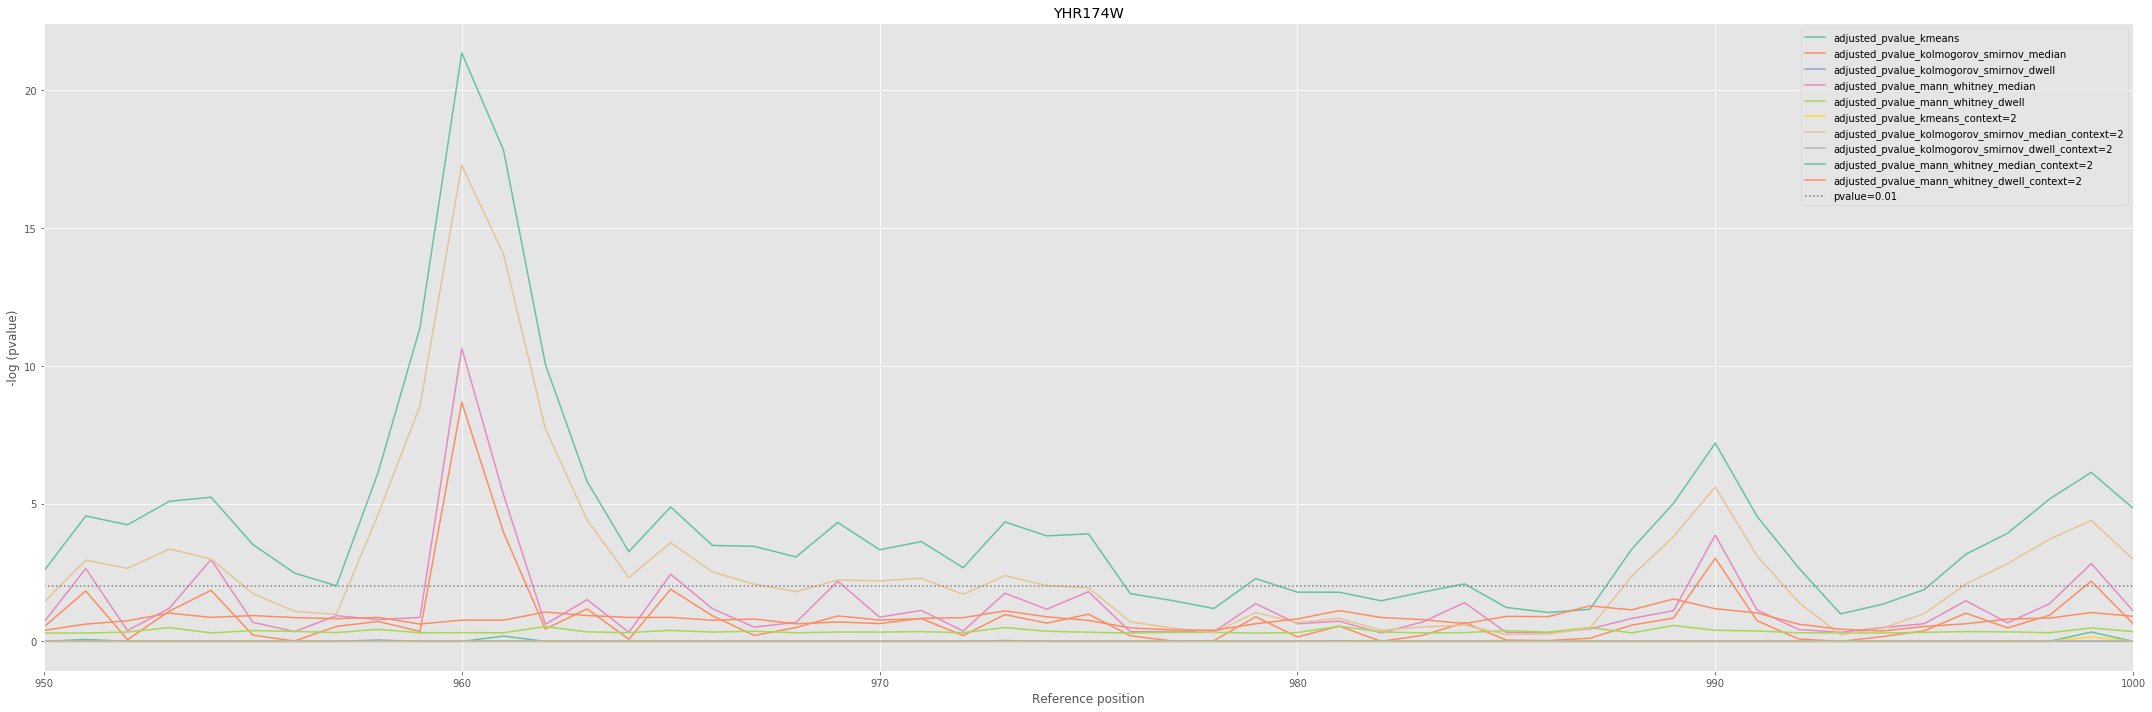

In [3]:
db = SampCompDB (db_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/test/out.db", fasta_fn="/home/aleg/Analyses/RNA_Yeast_TRM5/references/SC_R64-1-1_transcripts_clean.fa")
db.calculate_results()
fig, ax = db.plot_signal ("YHR174W", start=950, end=1000)
fig, ax = db.plot_coverage ("YHR174W", start=950, end=1000)
fig, ax = db.plot_pvalue ("YHR174W", start=950, end=1000)